In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'mvn_exp_25b555f93a518efa82dad2e30bdbe8f8' in c['name'] 
        and c['generator'] == 'DDPM'
        # and c['config']['dataset']['set_size'] == 500
]

In [3]:
cfgs

[{'name': 'mvn_exp_25b555f93a518efa82dad2e30bdbe8f8',
  'dir': '../outputs/mvn_exp_25b555f93a518efa82dad2e30bdbe8f8',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultivariateNormalDistributionDataset', 'n_sets': 50000, 'set_size': '${experiment.set_size}', 'data_shape': [2], 'seed': '${seed}', 'prior_mu': [0, 5], 'prior_cov_df': 10, 'prior_cov_scale': 1}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderGNN', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 2, 'fc_layers': 2}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 16, 1], 'hidden_dim': 64, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.lr}'

In [4]:
import hydra
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [5]:
from torch.utils.data import DataLoader
ds = prepare_dataset(cfgs[0]['config']['dataset'])
dl = DataLoader(ds, batch_size=16, shuffle=True)

In [6]:
import numpy as np
import torch
import gc


from ot.gmm import dist_bures_squared

latent_dists = []
ot_dists = []

gc.collect()
torch.cuda.empty_cache()

for i, (batch_s, batch_t) in enumerate(zip(iter(dl), iter(dl))):
    print(f'{i}/{len(dl)}')
    samples_s = batch_s['samples'].to(device)
    means_s = batch_s['mean'].to(device)
    covs_s = batch_s['cov'].to(device)
    samples_t = batch_t['samples'].to(device)
    means_t = batch_t['mean'].to(device)
    covs_t = batch_t['cov'].to(device)

    with torch.no_grad():
        enc_s = enc(samples_s).detach().cpu().numpy()
        enc_t = enc(samples_t).detach().cpu().numpy()


    latent_dists.append(np.linalg.norm(enc_s - enc_t, axis=1))
    # this is simply impossible to vectorize, vmap fails because they compute the sinkhorn with numpy primitives
    ot_dists += [
        dist_bures_squared(means_si.unsqueeze(0), means_ti.unsqueeze(0), covs_si.unsqueeze(0), covs_ti.unsqueeze(0)).detach().cpu().numpy() 
        for means_si, means_ti, covs_si, covs_ti in zip(means_s, means_t, covs_s, covs_t)
    ]

    # clear cuda cache
    gc.collect()
    torch.cuda.empty_cache()

latent_dists = np.concatenate(latent_dists)
ot_dists = np.sqrt(np.array(ot_dists).flatten())


0/3125
1/3125
2/3125
3/3125
4/3125
5/3125
6/3125
7/3125
8/3125
9/3125
10/3125
11/3125
12/3125
13/3125
14/3125
15/3125
16/3125
17/3125
18/3125
19/3125
20/3125
21/3125
22/3125
23/3125
24/3125
25/3125
26/3125
27/3125
28/3125
29/3125
30/3125
31/3125
32/3125
33/3125
34/3125
35/3125
36/3125
37/3125
38/3125
39/3125
40/3125
41/3125
42/3125
43/3125
44/3125
45/3125
46/3125
47/3125
48/3125
49/3125
50/3125
51/3125
52/3125
53/3125
54/3125
55/3125
56/3125
57/3125
58/3125
59/3125
60/3125
61/3125
62/3125
63/3125
64/3125
65/3125
66/3125
67/3125
68/3125
69/3125
70/3125
71/3125
72/3125
73/3125
74/3125
75/3125
76/3125
77/3125
78/3125
79/3125
80/3125
81/3125
82/3125
83/3125
84/3125
85/3125
86/3125
87/3125
88/3125
89/3125
90/3125
91/3125
92/3125
93/3125
94/3125
95/3125
96/3125
97/3125
98/3125
99/3125
100/3125
101/3125
102/3125
103/3125
104/3125
105/3125
106/3125
107/3125
108/3125
109/3125
110/3125
111/3125
112/3125
113/3125
114/3125
115/3125
116/3125
117/3125
118/3125
119/3125
120/3125
121/3125
122/3125
123

In [3]:
import numpy as np

# load from numerical results
data = np.load('../numerical_results/mvn_dists.npz')
latent_dists = data['gde_dists']
ot_dists = data['ot_dists']


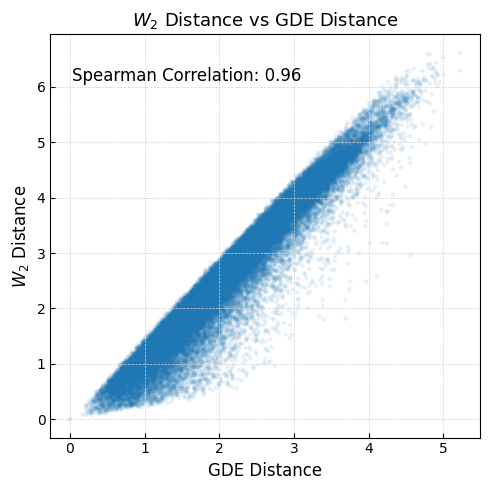

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Set up figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plot scatter
ax.scatter(latent_dists, ot_dists.flatten(), alpha=0.1, s=10, edgecolor='none')

# Labels and title
ax.set_xlabel('GDE Distance', fontsize=12)
ax.set_ylabel('$W_2$ Distance', fontsize=12)
ax.set_title('$W_2$ Distance vs GDE Distance', fontsize=13)

# Grid: light gray, dashed, thin — to match other plots
ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)

# Ticks inside, no top/right ticks
ax.tick_params(direction='in', top=False, right=False)

# Tighten layout
plt.tight_layout()

# Annotate correlation
rho, _ = spearmanr(latent_dists, ot_dists.flatten())
ax.text(0.05, 0.92, f'Spearman Correlation: {rho:.2f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Save
plt.savefig('../figs/mvn_dists.png', dpi=300)
plt.show()

# save actual data to numerical results
np.savez(
    '../numerical_results/mvn_dists.npz', 
    gde_dists=latent_dists, 
    ot_dists=ot_dists
)

